# FINAL PROJECT IN DATA SCIENCE 2023

#### By: Snir Taub and Nir Aizen

# **What factors influence the popularity of video games, and how can machine learning models be used to predict the popularity of video games**


##  <code style="background:yellow;color:black">Introduction:</code>


#### The motivation for this project is commercial, as video game developers and publishers are constantly looking for ways to create and promote games that will be successful in the market. By identifying the key features that make a game popular, they can better target their marketing efforts and create games that will be more successful

In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import Select
from selenium.common.exceptions import TimeoutException
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
from pandas.api.types import is_datetime64_any_dtype as is_datetime
import sklearn as sk
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
import random
chrome_options = Options()
chrome_options.add_argument('--headless')

import time
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import bs4 as bs
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# <code style="background:yellow;color:black">Scraping Section:</code>

In this section, we utilize Selenium for web scraping to gather data from Moby Games. Selenium allows us to automate the process of visiting the website, interacting with web elements, and extracting relevant information. We navigate through the pages, extract data such as game titles, release dates, genres, ratings, etc... and store it for further analysis. By leveraging Selenium's capabilities, we efficiently collect a large volume of data from Moby Games to support our project objectives.

In [ ]:
# create an empty list to store the scraped data
all_data_list = []
all_data=pd.DataFrame(None)

# create an empty dataframe with the desired column names
df2 = pd.DataFrame(columns=['Genre', 'Perspective', 'Console'])

# create a webdriver object with custom options
driver = webdriver.Chrome()#options=chrome_options)

# set the size of the browser window
driver.set_window_size(1920, 1080)

# create a WebDriverWait object with a timeout of 10 seconds
wait = WebDriverWait(driver, 10)
game_names=[]           

url_names=["-added","critic_score","-critic_score","moby_score","-moby_score","user_score","-user_score","date", "-date","modified","-modified"] 

for names in url_names:
    for page_number in range(1, 27):
        url = f'https://www.mobygames.com/game/sort:{names}/page:{page_number}/'
        # navigate to the current page
        driver.get(url)
        #wait until the table element is present on the page
        table = wait.until(EC.presence_of_element_located((By.XPATH,'/html/body/div/main/div/div[2]/table')))
        # extract the table HTML and convert it to a Pandas dataframe
        table_html = table.get_attribute('outerHTML')
        table = pd.read_html(table_html)[0]
        df=pd.DataFrame(table.iloc[:,1])
        if names=="title" or names=="-title":
            df = pd.concat([df, table.iloc[:,2]], axis=1)
        else:
            df = pd.concat([df, table.iloc[:,3]], axis=1) 
         # loop through each game on the page
        for i in range(1, 19):
        # find and click on the game's URL
            game_url = wait.until(EC.presence_of_element_located((By.XPATH,f'/html/body/div/main/div/div[2]/table/tbody/tr[{i}]/td[2]/a')))
            game_url.click() # navigate to the game page
        # extract the genre, perspective, and console information from the game page (if available)
            try:
                critics=wait.until(EC.presence_of_element_located((By.XPATH, '/html/body/div/main/div[2]/div[3]/dl/dd[2]')))
            except TimeoutException:
                critics = None
            try:
                moby_score=wait.until(EC.presence_of_element_located((By.XPATH,'/html/body/div/main/div[2]/div[3]/dl/dd[1]/div')))
                if moby_score.text == "n/a":
                        moby_score= None
            except TimeoutException:
                                    moby_score = None 
            try:
                publishers = wait.until(EC.presence_of_element_located((By.XPATH, '/html/body/div/main/div[2]/div[2]/dl/dd[3]/ul')))
            except TimeoutException:
                publishers = None
            try:
                developers = wait.until(EC.presence_of_element_located((By.XPATH, '/html/body/div/main/div[2]/div[2]/dl/dd[3]/ul/li/a')))
            except TimeoutException:
                developers = None
            try:
                gameplay = wait.until(EC.presence_of_element_located((By.XPATH, '/html/body/div/main/div[2]/div[4]/dl/dd[3]')))
            except TimeoutException:
                gameplay = None
            try:
                genre = wait.until(EC.presence_of_element_located((By.XPATH, '/html/body/div/main/div[2]/div[4]/dl/dd[1]/a')))
            except TimeoutException:
                genre = None
            try:
                perspective = wait.until(EC.presence_of_element_located((By.XPATH, '/html/body/div/main/div[2]/div[4]/dl/dd[2]/a')))
            except TimeoutException:
                perspective = None
            try:
                console = wait.until(EC.presence_of_element_located((By.XPATH, '/html/body/div/main/div[2]/div[2]/dl/dd[1]/a[2]')))
            except TimeoutException:
                   console = None
            publishers_list = [a.text for a in publishers.find_elements(By.CSS_SELECTOR, 'a')] if publishers else [None]
            publishers_str = ', '.join(publisher for publisher in publishers_list if publisher)
            gameplay_list = [g.text for g in gameplay.find_elements(By.CSS_SELECTOR,'a')] if gameplay else [None]
            gameplay_str = ', '.join(game for game in gameplay_list if game)
            off_line=1
            multi=0
            # create a new dataframe with the extracted information
            new_row = pd.DataFrame({'Moby Score':[moby_score.text if moby_score else None],'Critics':[critics.text if critics else None],
                                    'Genre': [genre.text if genre else None],
                                    'Perspective':[perspective.text if perspective else None],'Console': [console.text if console else None],
                             'Publishers':[publishers_str],'Developers':[developers.text if developers else None],
                                'Multiplayer':[multi],'Offline Players':[off_line],'Gameplay':[gameplay_str]})
            
           # add the new row to the df2 dataframe
            df2 = pd.concat([df2, new_row], ignore_index=True)
           # navigate back to the previous page
            driver.back()
            
           # merge df and df2 to create a new dataframe
        new_data = pd.concat([df, df2], axis=1).reset_index(drop=True)
        df2=pd.DataFrame(None)
        all_data_list.append(new_data)
       
    # concatenate the list of dataframes to create a new all_data dataframe
        all_data = pd.concat(all_data_list, ignore_index=True)
    # replace NaN values with empty string
        all_data.fillna('', inplace=True)
    # rename columns
    new_column_names = ['Name', 'Year', 'Genre', 'Perspective', 'Console'] 
    all_data = all_data.rename(columns=dict(zip(all_data.columns.tolist(), new_column_names)))
data_set=pd.concat([all_data], ignore_index=True)
all_data=pd.DataFrame(None)
display(data_set)




In [2]:

#printing the Data Frame and saving it as a csv file
#data_set.to_csv('new_games_data_set.csv', index=False)
final_df = pd.read_csv('new_games_data_set.csv')
final_df

,Name,Year,Genre,Perspective,Console,Moby Score,Critics,Publishers,Developers,Multiplayer,Offline Players,Gameplay
0,Airball,1987,Action,Top-down,DOS,7.3,75% (11),"MicroDeal Ltd., Atari Corporation, Pixel Games UK",MicroDeal Ltd.,0.0,1.0,"Fixed / flip-screen, Isometric"
1,Beyond Zork: The Coconut of Quendor,1987,Adventure,Text-based / Spreadsheet,DOS,7.2,84% (13),"Infocom, Inc.","Infocom, Inc.",0.0,1.0,Fixed / flip-screen
2,Big Top,1983,Action,Side view,PC Booter,NaN,78% (1),"Funtastic, Inc.","Funtastic, Inc.",0.0,1.0,Fixed / flip-screen
3,Bop'N Wrestle,1985,Sports,Wrestling,Commodore 64,6.4,62% (5),"Melbourne House, Mindscape, Inc., Firebird Sof...",Melbourne House,0.0,1.0,NaN
4,Chessmaster 5000,1996,Strategy,Chess,Windows,7.6,81% (10),"Mindscape, Inc.","Mindscape, Inc.",0.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5143,Trucker 2,2015,Racing / Driving,3rd-person (Other),Windows,NaN,NaN,Silden,Silden,0.0,1.0,"Truck, Vehicle simulator"
5144,Toukiden 2: Armor - Tenko Outfit,2017,DLC / Add-on,Item,Windows,NaN,NaN,NaN,NaN,0.0,1.0,NaN
5145,Toukiden 2: Mitama - Sanada Masayuki,2017,DLC / Add-on,Item,Windows,NaN,NaN,NaN,NaN,0.0,1.0,NaN
5146,Toukiden 2: Mitama - Sanada Nobuyuki,2017,DLC / Add-on,Item,Windows,NaN,NaN,NaN,NaN,0.0,1.0,NaN


In [3]:
print("As can be seen there are some missing values in our data frame: " )
display(final_df.isnull().sum())
print("\n")

print("The number of duplicates rows:",final_df.duplicated().sum())


As can be seen there are some missing values in our data frame: 


Name                  0
Year                467
Genre                 2
Perspective         148
Console               2
Moby Score         1723
Critics             824
Publishers          640
Developers          640
Multiplayer           0
Offline Players       0
Gameplay            652
dtype: int64



The number of duplicates rows: 900


# <code style="background:yellow;color:black">Data Cleaning Section:</code>


In this section, we apply a series of techniques and methods to handle various data quality issues, such as missing values, inconsistent formatting, outliers, duplicates, and other anomalies that may affect the integrity and reliability of the data.

In [4]:
data = pd.read_csv('new_games_data_set.csv')
# Remove duplicate entries
data.drop_duplicates(inplace=True)

# Handle missing values
data.dropna(subset=['Name', 'Year', 'Genre', 'Perspective','Console', 'Moby Score', 'Critics', 'Publishers', 'Developers','Gameplay'], inplace=True)
data.fillna({'MobyScore': 0, 'Critics': 0}, inplace=True)

columns_to_drop = ['Multiplayer', 'Offline Players']

data.drop(columns=columns_to_drop,inplace=True)

# Standardize parameter formats
data['Name'] = data['Name'].str.title()
data['Genre'] = data['Genre'].str.lower()
data['Perspective'] = data['Perspective'].str.lower()
#it removes any text that starts with a percentage sign (%) 
#and includes any number of characters following it.
data['Critics'] = data['Critics'].str.replace('%.*', '', regex=True)

# Save the cleaned data to a new CSV file
data.to_csv('cleaned_data.csv', index=False)

# Finally, printing the cleaned dataset
my_cleaned_dataset = pd.read_csv('cleaned_data.csv')
display(my_cleaned_dataset)


,Name,Year,Genre,Perspective,Console,Moby Score,Critics,Publishers,Developers,Gameplay
0,Airball,1987,action,top-down,DOS,7.3,75,"MicroDeal Ltd., Atari Corporation, Pixel Games UK",MicroDeal Ltd.,"Fixed / flip-screen, Isometric"
1,Beyond Zork: The Coconut Of Quendor,1987,adventure,text-based / spreadsheet,DOS,7.2,84,"Infocom, Inc.","Infocom, Inc.",Fixed / flip-screen
2,Cosmic Crusader,1982,action,top-down,PC Booter,7.0,(15),"Funtastic, Inc.","Funtastic, Inc.","Arcade, Shooter"
3,Deadline,1982,adventure,text-based / spreadsheet,PC Booter,7.6,85,"Infocom, Inc., Commodore Business Machines (UK...","Infocom, Inc.",Fixed / flip-screen
4,Digger,1983,action,side view,PC Booter,7.2,82,Windmill Software Inc.,Windmill Software Inc.,Fixed / flip-screen
...,...,...,...,...,...,...,...,...,...,...
2304,Word Rescue,1992,action,side view,DOS,6.7,(16),"FormGen, Inc., Apogee Software, Ltd., 3D Realm...","FormGen, Inc.",2D scrolling
2305,Thimbleweed Park,2017,adventure,3rd-person (other),Windows,8.2,83,"Terrible Toybox, Inc.","Terrible Toybox, Inc.",2D scrolling
2306,Psychotoxic,2004,action,1st-person,Windows,5.3,50,Nuclearvision Entertainment GmbH,Nuclearvision Entertainment GmbH,Shooter
2307,The Bugs Bunny Crazy Castle,1989,action,side view,Game Boy,6.6,61,"Kotobuki System Co., Ltd.","Kotobuki System Co., Ltd.",2D scrolling


In [5]:
print("Lets see the amount of NaN values after cleaning the data : " )
display(my_cleaned_dataset.isnull().sum())
print("\n")

print("The number of duplicates rows after cleaning:",my_cleaned_dataset.duplicated().sum())

Lets see the amount of NaN values after cleaning the data : 


Name           0
Year           0
Genre          0
Perspective    0
Console        0
Moby Score     0
Critics        0
Publishers     0
Developers     0
Gameplay       0
dtype: int64



The number of duplicates rows after cleaning: 0


# <code style="background:yellow;color:black">Data Analysis & Processing Section: </code>


In this section, we analyze and process the collected data to gain insights and prepare it for further analysis and modeling. Specifically, we perform the following tasks:

* Genre & Perspective Column's Separation: We separate the genre and perspective columns into binary columns representing the main genres and perspectives. This allows for easier analysis and comparison of genre/perspective presence in the dataset.


* Analysis of Games, Developers, Publishers, and Main Genres/Perspectives: We examine the number of unique games, developers, publishers, and main genres/perspectives present in the dataset. This analysis provides insights into the variety and distribution of these factors.


* Addition of Binary Column for Successful Games: We add a binary column indicating whether a game is considered successful based on predefined criteria. This allows for the classification of games as successful or not for further analysis.

<div class="alert alert-block alert-info">
<b>Note:</b> Transferring categorical data into numeric form is important because many machine learning algorithms require numerical inputs. These algorithms use mathematical equations and computations to make predictions or learn patterns from the data. Therefore, categorical data, which represents non-numeric values, needs to be converted into numeric form for these algorithms to process the data effectively.
</div>

In [6]:
# Define the genres to check
genres = ['action', 'adventure', 'role-playing', 'puzzle', 'simulation', 'dlc', 'strategy', 'racing', 'educational', 'sports']
# Iterate over the genres and create a new binary column for each genre
for genre in genres: 
    column_name = 'is_' + genre.replace('-', '_')
    my_cleaned_dataset[column_name] = my_cleaned_dataset['Genre'].str.contains(genre, case=False).astype(int)

# Print the columns representing the genres
genre_columns = ['is_' + genre.replace('-', '_') for genre in genres]
display(my_cleaned_dataset[genre_columns])




,is_action,is_adventure,is_role_playing,is_puzzle,is_simulation,is_dlc,is_strategy,is_racing,is_educational,is_sports
0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2304,1,0,0,0,0,0,0,0,0,0
2305,0,1,0,0,0,0,0,0,0,0
2306,1,0,0,0,0,0,0,0,0,0
2307,1,0,0,0,0,0,0,0,0,0


#### In the next block of code we identifiey the main perspectives (those appearing more than once) in the "Perspective" column of the my_cleaned_dataset DataFrame. Then creates binary indicator columns for each main perspective and adds them to the DataFrame.

<div class="alert alert-block alert-info">
<b>Note:</b> In this section, we performed categorical data transformation by converting it into a numeric representation. The primary motivation behind this transformation is to make the data understandable for machine learning algorithms.
    
Furthermore, by filtering the perspectives that appear more than once in the dataset, we gain valuable insights for the EDA process. This filtering process allows us to understand the distribution and prevalence of different perspectives within the dataset. 
</div>

In [7]:
perspective_counts = my_cleaned_dataset['Perspective'].value_counts()
main_perspectives = perspective_counts[perspective_counts > 1]
main_perspectives_names = main_perspectives.index.tolist()
for name in main_perspectives_names:
    my_cleaned_dataset[name] = my_cleaned_dataset['Perspective'].apply(lambda x: 1 if x == name else 0)
display(my_cleaned_dataset[main_perspectives_names])
display(my_cleaned_dataset)

,1st-person,side view,3rd-person (other),behind view,diagonal-down,top-down,interactive fiction / text adventure,text-based / spreadsheet,isometric,turn-based,managerial / business simulation,fixed / flip-screen,real-time,platform,arcade,anime / manga,full motion video (fmv),menu structures,map / level,board game,game show / trivia / quiz
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2304,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2305,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2306,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2307,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,Name,Year,Genre,Perspective,Console,Moby Score,Critics,Publishers,Developers,Gameplay,is_action,is_adventure,is_role_playing,is_puzzle,is_simulation,is_dlc,is_strategy,is_racing,is_educational,is_sports,1st-person,side view,3rd-person (other),behind view,diagonal-down,top-down,interactive fiction / text adventure,text-based / spreadsheet,isometric,turn-based,managerial / business simulation,fixed / flip-screen,real-time,platform,arcade,anime / manga,full motion video (fmv),menu structures,map / level,board game,game show / trivia / quiz
0,Airball,1987,action,top-down,DOS,7.3,75,"MicroDeal Ltd., Atari Corporation, Pixel Games UK",MicroDeal Ltd.,"Fixed / flip-screen, Isometric",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Beyond Zork: The Coconut Of Quendor,1987,adventure,text-based / spreadsheet,DOS,7.2,84,"Infocom, Inc.","Infocom, Inc.",Fixed / flip-screen,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Cosmic Crusader,1982,action,top-down,PC Booter,7.0,(15),"Funtastic, Inc.","Funtastic, Inc.","Arcade, Shooter",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Deadline,1982,adventure,text-based / spreadsheet,PC Booter,7.6,85,"Infocom, Inc., Commodore Business Machines (UK...","Infocom, Inc.",Fixed / flip-screen,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Digger,1983,action,side view,PC Booter,7.2,82,Windmill Software Inc.,Windmill Software Inc.,Fixed / flip-screen,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2304,Word Rescue,1992,action,side view,DOS,6.7,(16),"FormGen, Inc., Apogee Software, Ltd., 3D Realm...","FormGen, Inc.",2D scrolling,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2305,Thimbleweed Park,2017,adventure,3rd-person (other),Windows,8.2,83,"Terrible Toybox, Inc.","Terrible Toybox, Inc.",2D scrolling,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2306,Psychotoxic,2004,action,1st-person,Windows,5.3,50,Nuclearvision Entertainment GmbH,Nuclearvision Entertainment GmbH,Shooter,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2307,The Bugs Bunny Crazy Castle,1989,action,side view,Game Boy,6.6,61,"Kotobuki System Co., Ltd.","Kotobuki System Co., Ltd.",2D scrolling,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
print("Total cells: " + str(2309*41))

Total cells: 94669


<div class="alert alert-block alert-info">
<b>Note:</b> Here we perform data type conversions, and scaling operations on the 'Moby Score' and 'Critics' columns.
 These operations aim to ensure consistent data types, transform non-numeric characters into numeric representations, and potentially improve compatibility or analysis capabilities by calculating the average score between both of them. 
</div>

In [9]:
my_cleaned_dataset['Moby Score'] = my_cleaned_dataset['Moby Score'].astype(float) * 10
# Remove non-numeric characters from 'Critics' column by replacing them with an empty string.
my_cleaned_dataset['Critics'] = my_cleaned_dataset['Critics'].astype(str).str.replace(r'\D', '',regex=True).astype(int)
my_cleaned_dataset['Critics'] = my_cleaned_dataset['Critics'].astype(int)
my_cleaned_dataset['Moby Score'] = my_cleaned_dataset['Moby Score'].astype(int)
display(my_cleaned_dataset)

,Name,Year,Genre,Perspective,Console,Moby Score,Critics,Publishers,Developers,Gameplay,is_action,is_adventure,is_role_playing,is_puzzle,is_simulation,is_dlc,is_strategy,is_racing,is_educational,is_sports,1st-person,side view,3rd-person (other),behind view,diagonal-down,top-down,interactive fiction / text adventure,text-based / spreadsheet,isometric,turn-based,managerial / business simulation,fixed / flip-screen,real-time,platform,arcade,anime / manga,full motion video (fmv),menu structures,map / level,board game,game show / trivia / quiz
0,Airball,1987,action,top-down,DOS,73,75,"MicroDeal Ltd., Atari Corporation, Pixel Games UK",MicroDeal Ltd.,"Fixed / flip-screen, Isometric",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Beyond Zork: The Coconut Of Quendor,1987,adventure,text-based / spreadsheet,DOS,72,84,"Infocom, Inc.","Infocom, Inc.",Fixed / flip-screen,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Cosmic Crusader,1982,action,top-down,PC Booter,70,15,"Funtastic, Inc.","Funtastic, Inc.","Arcade, Shooter",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Deadline,1982,adventure,text-based / spreadsheet,PC Booter,76,85,"Infocom, Inc., Commodore Business Machines (UK...","Infocom, Inc.",Fixed / flip-screen,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Digger,1983,action,side view,PC Booter,72,82,Windmill Software Inc.,Windmill Software Inc.,Fixed / flip-screen,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2304,Word Rescue,1992,action,side view,DOS,67,16,"FormGen, Inc., Apogee Software, Ltd., 3D Realm...","FormGen, Inc.",2D scrolling,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2305,Thimbleweed Park,2017,adventure,3rd-person (other),Windows,82,83,"Terrible Toybox, Inc.","Terrible Toybox, Inc.",2D scrolling,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2306,Psychotoxic,2004,action,1st-person,Windows,53,50,Nuclearvision Entertainment GmbH,Nuclearvision Entertainment GmbH,Shooter,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2307,The Bugs Bunny Crazy Castle,1989,action,side view,Game Boy,66,61,"Kotobuki System Co., Ltd.","Kotobuki System Co., Ltd.",2D scrolling,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
# Calculating the average score between Moby Score & Critics score and storing it into new column (avg_score)
my_cleaned_dataset['Moby Score'] = my_cleaned_dataset['Moby Score'].astype(int)
my_cleaned_dataset['avg_score'] = my_cleaned_dataset[['Moby Score', 'Critics']].mean(axis=1)
my_cleaned_dataset['avg_score']


0       74.0
1       78.0
2       42.5
3       80.5
4       77.0
        ... 
2304    41.5
2305    82.5
2306    51.5
2307    63.5
2308    82.5
Name: avg_score, Length: 2309, dtype: float64

In [11]:
print('Different Games:')
print(len(my_cleaned_dataset.Name.value_counts()))

print("Different Developers:")
print(len(my_cleaned_dataset.Developers.value_counts()))

print("Different Publishers:")
print(len(my_cleaned_dataset.Publishers.value_counts()))

print("Main Genres")
print(10)

print("Main Perspectives")
print(21)


Different Games:
2251
Different Developers:
1055
Different Publishers:
1745
Main Genres
10
Main Perspectives
21


<div class="alert alert-block alert-info">
<b>Note:</b> Here we iterates through each score in the 'avg_score' column, and if the score is equal or greater than 80, it is considered successful and appended with a value of 1 to the 'is_success' column. Otherwise, a value of 0 is appended to represent an unsuccessful game.  
</div>

In [12]:
is_success = []  # Create an empty list to store success values
for score in my_cleaned_dataset['avg_score']:
    if score >= 80:  # Check if the avg_score is greater than or equal to 80
        is_success.append(1)  # Append 1 to the is_success list if it is successful
    else:
        is_success.append(0)  # Append 0 if it is unsuccessful

my_cleaned_dataset['is_success'] = is_success  # Add the is_success list as a new column in the dataset

# Calculate the total number of successful and unsuccessful games using len() and filtering
total_successful_games = len(my_cleaned_dataset[my_cleaned_dataset['is_success'] == 1])
total_unsuccessful_games = len(my_cleaned_dataset[my_cleaned_dataset['is_success'] == 0])

# Print the total number of successful and unsuccessful games
print(f"Total {total_successful_games} successful games")
print(f"Total {total_unsuccessful_games} unsuccessful games")


Total 848 successful games
Total 1461 unsuccessful games


In [13]:
my_cleaned_dataset.describe()

,Moby Score,Critics,is_action,is_adventure,is_role_playing,is_puzzle,is_simulation,is_dlc,is_strategy,is_racing,is_educational,is_sports,1st-person,side view,3rd-person (other),behind view,diagonal-down,top-down,interactive fiction / text adventure,text-based / spreadsheet,isometric,turn-based,managerial / business simulation,fixed / flip-screen,real-time,platform,arcade,anime / manga,full motion video (fmv),menu structures,map / level,board game,game show / trivia / quiz,avg_score,is_success
count,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000,2309.000000
mean,67.831096,65.402772,0.566912,0.109138,0.076223,0.019489,0.034214,0.005630,0.053703,0.053703,0.007796,0.064963,0.240364,0.223040,0.146384,0.131226,0.114335,0.084452,0.009961,0.009528,0.008662,0.003465,0.003465,0.003032,0.002599,0.002165,0.002165,0.001299,0.001299,0.001299,0.001299,0.000866,0.000866,66.616934,0.367259
std,15.865009,24.167109,0.495610,0.311880,0.265413,0.138266,0.181818,0.074839,0.225479,0.225479,0.087967,0.246514,0.427397,0.416375,0.353567,0.337720,0.318287,0.278125,0.099328,0.097166,0.092685,0.058772,0.058772,0.054988,0.050921,0.046494,0.046494,0.036030,0.036030,0.036030,0.036030,0.029424,0.029424,19.561516,0.482162
min,22.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000
25%,52.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.500000,0.000000
50%,73.000000,74.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.000000,0.000000
75%,82.000000,87.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,85.000000,1.000000
max,94.000000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,95.500000,1.000000



# <code style="background:yellow;color:black">EDA Section: </code>


The EDA section involves analyzing the dataset to understand the average scores (Average score, Moby Score, Critics Score) and the distribution of games across different categories or genres influenced by decades and ratings. This analysis helps identify trends and factors contributing to a game's popularity based on its features.

###### <code style="background:lightblue;color:black">Average score representation:</code>


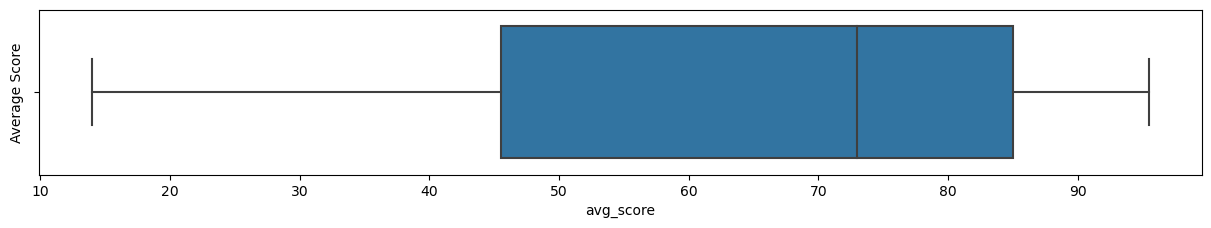

The average score is: 66.61693373754872


In [14]:
plt.figure(figsize=(15, 15))
plt.subplot(6, 1, 1)
sns.boxplot(data=my_cleaned_dataset, x="avg_score")
plt.ylabel("Average Score")
plt.show()
print("The average score is: " + str(my_cleaned_dataset['avg_score'].mean()))


###### <code style="background:lightblue;color:black">Moby score representation:</code>


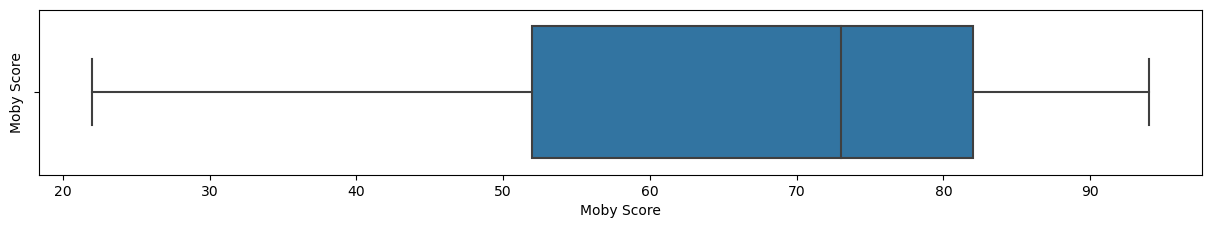

The average score is: 67.83109571242963


In [15]:
plt.figure(figsize=(15, 15))
plt.subplot(6, 1, 1)
sns.boxplot(data=my_cleaned_dataset, x="Moby Score")
plt.ylabel("Moby Score")
plt.show()
print("The average score is: " + str(my_cleaned_dataset['Moby Score'].mean()))

###### <code style="background:lightblue;color:black">Critics score representation:</code>


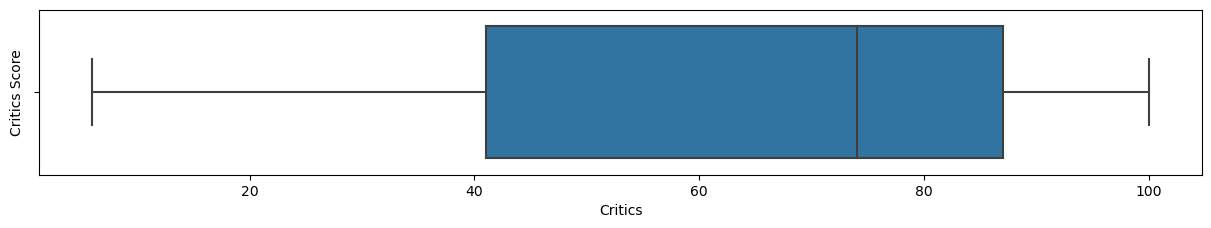

The average score is: 65.40277176266783


In [16]:
plt.figure(figsize=(15, 15))
plt.subplot(6, 1, 1)
sns.boxplot(data=my_cleaned_dataset, x="Critics")
plt.ylabel("Critics Score")
plt.show()
print("The average score is: " + str(my_cleaned_dataset['Critics'].mean()))

### <code style="background:lightblue;color:black">Total Games Distribution by Genre:</code>

<div class="alert alert-block alert-info">
<b>Note:</b> 
Calculating the total number of games in each genre category by using "len()" function to count the number of rows that have the same genres
</div>

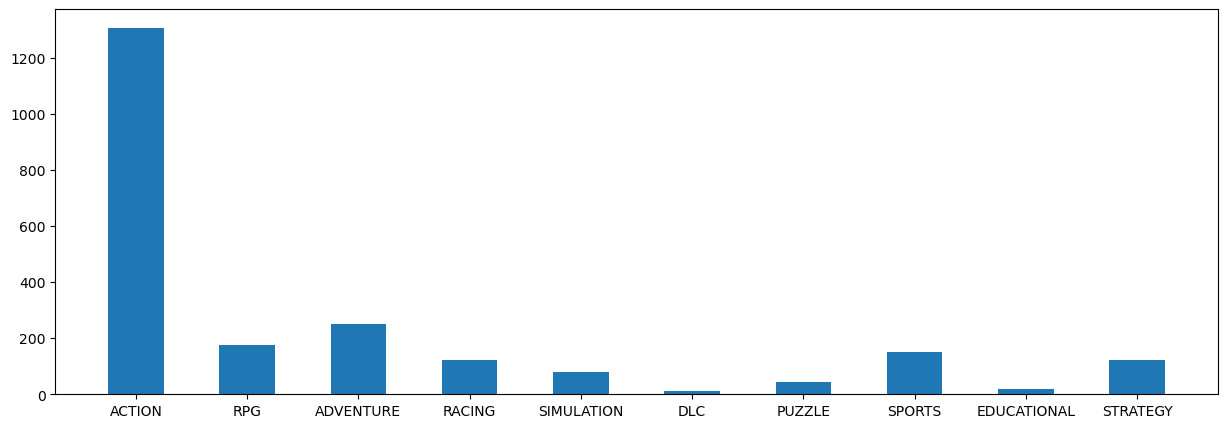

In [17]:
# Showing the total games of each category

# Define the names of the genres
names = ["ACTION", "RPG", "ADVENTURE", "RACING", "SIMULATION", "DLC", "PUZZLE", "SPORTS", "EDUCATIONAL", "STRATEGY"]
fig = plt.figure(figsize=(15,5))

# Calculate the scores for each genre
scores = [
    len(my_cleaned_dataset[my_cleaned_dataset['is_action'] == 1]),
    len(my_cleaned_dataset[my_cleaned_dataset['is_role_playing'] == 1]),
    len(my_cleaned_dataset[my_cleaned_dataset['is_adventure'] == 1]),
    len(my_cleaned_dataset[my_cleaned_dataset['is_racing'] == 1]),
    len(my_cleaned_dataset[my_cleaned_dataset['is_simulation'] == 1]),
    len(my_cleaned_dataset[my_cleaned_dataset['is_dlc'] == 1]),
    len(my_cleaned_dataset[my_cleaned_dataset['is_puzzle'] == 1]),
    len(my_cleaned_dataset[my_cleaned_dataset['is_sports'] == 1]),
    len(my_cleaned_dataset[my_cleaned_dataset['is_educational'] == 1]),
    len(my_cleaned_dataset[my_cleaned_dataset['is_strategy'] == 1])
]

# Define the positions for the bars on the x-axis
pos = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Create a bar plot
plt.bar(pos, scores, width=0.5)

# Set the tick labels for the x-axis
plt.xticks(pos, names)

# Display the plot
plt.show()



In [18]:

print("Developers:")
print(my_cleaned_dataset["Developers"].value_counts())
print("\n")
print("Publishers:")
print(my_cleaned_dataset["Publishers"].value_counts())

Developers:
Electronic Arts, Inc.                            75
Sierra On-Line, Inc.                             56
Capcom Co., Ltd.                                 35
Nintendo Co., Ltd.                               34
Infocom, Inc.                                    26
                                                 ..
Trend Redaktions- und Verlagsgesellschaft mbH     1
collision-studios GmbH                            1
Ignition Entertainment Ltd.                       1
AniVision                                         1
Sony Online Entertainment Inc.                    1
Name: Developers, Length: 1055, dtype: int64


Publishers:
Electronic Arts, Inc.                                                    39
Nintendo Co., Ltd., Nintendo of America Inc., Nintendo of Europe GmbH    16
Activision Publishing, Inc.                                              16
Sierra On-Line, Inc., U.S. Gold Ltd.                                     13
Sierra On-Line, Inc.                                 


### <code style="background:lightblue;color:black">Analysis of Unique Perspectives in the Dataset:</code>


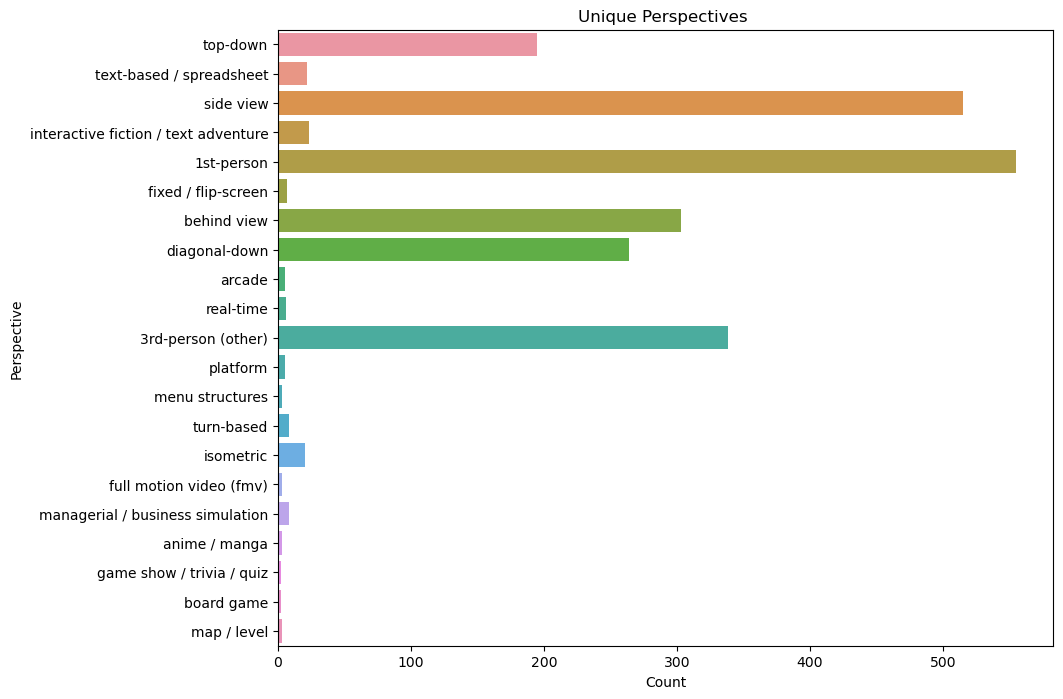

In [19]:
# Calculating the frequency of each unique perspective
perspective_counts = my_cleaned_dataset['Perspective'].value_counts()
# Selecting the main perspectives that appear more than once
main_perspectives = perspective_counts[perspective_counts > 1]
# Extracting the names of the main perspectives
main_perspectives_names = main_perspectives.index.tolist()
#creating binary column for each persoective
for name in main_perspectives_names:
    my_cleaned_dataset[name] = my_cleaned_dataset['Perspective'].apply(lambda x: 1 if x == name else 0)
    
# Filter the dataset to include only the rows with main perspectives
filtered_dataset = my_cleaned_dataset[my_cleaned_dataset['Perspective'].isin(main_perspectives_names)]

plt.figure(figsize=(10, 8))
sns.countplot(data=filtered_dataset, y='Perspective')
plt.xlabel('Count')
plt.ylabel('Perspective')
plt.title('Unique Perspectives ')
plt.show()

In [20]:
display(my_cleaned_dataset['Perspective'].describe())

print("As can be seen the most common prespective is:",my_cleaned_dataset['Perspective'].value_counts().idxmax())

count           2309
unique            40
top       1st-person
freq             555
Name: Perspective, dtype: object

As can be seen the most common prespective is: 1st-person


### <code style="background:lightblue;color:black">Comparison of Genres by Average Score (Decades):</code>


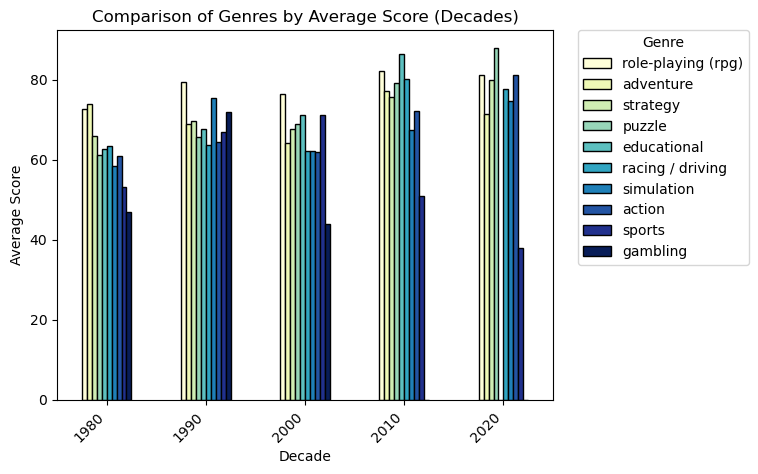

In [21]:
# Convert 'Year' column to datetime type, handle invalid values as NaN
my_cleaned_dataset['Year'] = pd.to_datetime(my_cleaned_dataset['Year'], format='%Y', errors='coerce')

# Filter the data starting from 1980 and exclude specific genres
filtered_dataset = my_cleaned_dataset[(my_cleaned_dataset['Year'].dt.year >= 1980) & 
                                      (~my_cleaned_dataset['Genre'].isin(['compilation', 'dlc / add-on', 'special edition', 'idle']))]

# Create a pivot table to compare genres by year and average score
pivot_table = filtered_dataset.pivot_table(index='Year', columns='Genre', values='avg_score')

# Convert average scores to numeric values
pivot_table = pivot_table.apply(pd.to_numeric)

# Calculate average scores across all years
average_scores = pivot_table.mean().sort_values(ascending=False)

# Define the decades starting from 1980
decades = range(1980, pivot_table.index.max().year // 10 * 10 + 10, 10)

# Create a new dataframe to store the average scores by decade
decade_scores = pd.DataFrame(index=decades, columns=average_scores.index)

# Calculate the average score for each genre in each decade
for decade in decades:
    start_year = pd.to_datetime(decade, format='%Y')
    end_year = start_year + pd.offsets.DateOffset(years=9)
    subset_pivot_table = pivot_table.loc[(pivot_table.index >= start_year) & (pivot_table.index <= end_year)]
    decade_scores.loc[decade] = subset_pivot_table.mean()

# Plot the bar plot
decade_scores.plot(kind='bar', cmap='YlGnBu', edgecolor='black')
plt.xlabel('Decade')
plt.ylabel('Average Score')
plt.title('Comparison of Genres by Average Score (Decades)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Genre',bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.show()


In [22]:
# Calculate the average score for each genre in each decade
for decade in decades:
    start_year = pd.to_datetime(decade, format='%Y')
    end_year = start_year + pd.offsets.DateOffset(years=9)
    subset_pivot_table = pivot_table.loc[(pivot_table.index >= start_year) & (pivot_table.index <= end_year)]
    decade_scores.loc[decade] = subset_pivot_table.mean()

# Extract important information from each decade
summary = []
for decade in decades:
    average_scores_decade = decade_scores.loc[decade].sort_values(ascending=False)
    top_genre = average_scores_decade.index[0]
    top_score = average_scores_decade.iloc[0]
    summary.append((decade, top_genre, top_score))

# Print the summary information for each decade
for decade_info in summary:
    decade = decade_info[0]
    top_genre = decade_info[1]
    top_score = decade_info[2]
    print(f"In the {decade}s, the top genre was {top_genre} with an average score of {top_score:.2f}.")


In the 1980s, the top genre was adventure with an average score of 73.91.
In the 1990s, the top genre was role-playing (rpg) with an average score of 79.53.
In the 2000s, the top genre was role-playing (rpg) with an average score of 76.45.
In the 2010s, the top genre was educational with an average score of 86.50.
In the 2020s, the top genre was puzzle with an average score of 88.00.


### <code style="background:lightblue;color:black">Perspective and their Average Scores by Decades:</code>


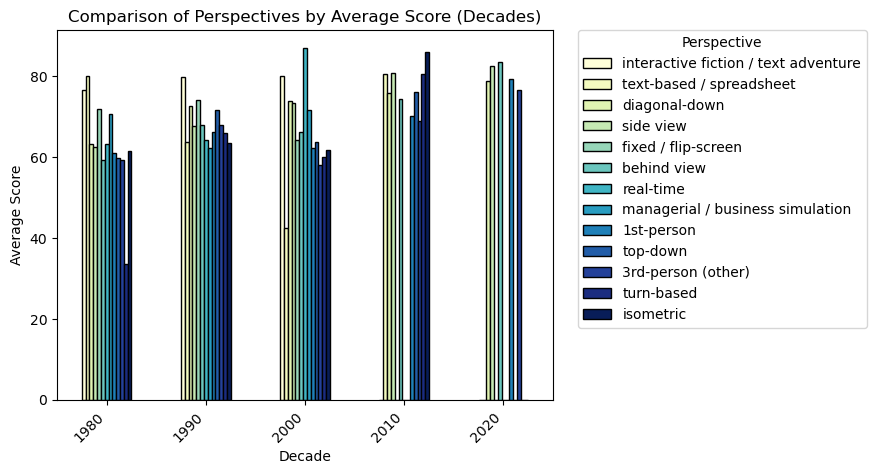

In [23]:
# Convert 'Year' column to datetime type, handle invalid values as NaN
my_cleaned_dataset['Year'] = pd.to_datetime(my_cleaned_dataset['Year'], format='%Y', errors='coerce')

# Calculate perspective counts
perspective_counts = my_cleaned_dataset['Perspective'].value_counts()

# Filter the data starting from 1980 and exclude perspectives with count <= 5
filtered_dataset = my_cleaned_dataset[
    (my_cleaned_dataset['Year'].dt.year >= 1980) &
    my_cleaned_dataset['Perspective'].isin(perspective_counts[perspective_counts > 5].index)
]

# Create a pivot table to compare perspectives by year and average score
pivot_table = filtered_dataset.pivot_table(index='Year', columns='Perspective', values='avg_score')

# Convert average scores to numeric values
pivot_table = pivot_table.apply(pd.to_numeric)

# Calculate average scores across all years
average_scores = pivot_table.mean().sort_values(ascending=False)

# Define the decades starting from 1980
decades = range(1980, pivot_table.index.max().year // 10 * 10 + 10, 10)

# Create a new dataframe to store the average scores by decade
decade_scores = pd.DataFrame(index=decades, columns=average_scores.index)

# Calculate the average score for each perspective in each decade
for decade in decades:
    start_year = pd.to_datetime(decade, format='%Y')
    end_year = start_year + pd.offsets.DateOffset(years=9)
    subset_pivot_table = pivot_table.loc[(pivot_table.index >= start_year) & (pivot_table.index <= end_year)]
    decade_scores.loc[decade] = subset_pivot_table.mean()

# Plot the bar plot
decade_scores.plot(kind='bar', cmap='YlGnBu', edgecolor='black')
plt.xlabel('Decade')
plt.ylabel('Average Score')
plt.title('Comparison of Perspectives by Average Score (Decades)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Perspective', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.show()


In [24]:
# Calculate the average score for each perspective in each decade
for decade in decades:
    start_year = pd.to_datetime(decade, format='%Y')
    end_year = start_year + pd.offsets.DateOffset(years=9)
    subset_pivot_table = pivot_table.loc[(pivot_table.index >= start_year) & (pivot_table.index <= end_year)]
    decade_scores.loc[decade] = subset_pivot_table.mean()

# Extract important information from each decade
summary = []
for decade in decades:
    average_scores_decade = decade_scores.loc[decade].sort_values(ascending=False)
    top_perspective = average_scores_decade.index[0]
    top_score = average_scores_decade.iloc[0]
    summary.append((decade, top_perspective, top_score))

# Print the summary information for each decade
for decade_info in summary:
    decade = decade_info[0]
    top_perspective = decade_info[1]
    top_score = decade_info[2]
    print(f"In the {decade}s, the top perspective was {top_perspective} with an average score of {top_score:.2f}.")


In the 1980s, the top perspective was text-based / spreadsheet with an average score of 79.95.
In the 1990s, the top perspective was interactive fiction / text adventure with an average score of 79.75.
In the 2000s, the top perspective was real-time with an average score of 87.00.
In the 2010s, the top perspective was isometric with an average score of 86.00.
In the 2020s, the top perspective was behind view with an average score of 83.35.


# <code style="background:yellow;color:black">Data Engineering: </code>
Creating the ml_df DataFrame for Machine Learning Algorithms.
<div class="alert alert-block alert-info">
<b>Note:</b> 
Factorizing Categorical Features: The 'Developers', 'Publishers', and 'Gameplay' columns are factorized using the pd.factorize() function. This assigns a unique numeric label to each distinct category within these columns. It enables the representation of categorical data in a format that can be understood by machine learning algorithms. and converting the years to string

</div>


### <code style="background:lightblue;color:black">Encoding Categorical Variables:</code>



In [25]:
ml_df = my_cleaned_dataset.copy()
ml_df["Developers"] = pd.factorize(my_cleaned_dataset.Developers)[0]
ml_df["Publishers"] = pd.factorize(my_cleaned_dataset.Publishers)[0]
ml_df["Gameplay"] = pd.factorize(my_cleaned_dataset.Gameplay)[0]
# Extracting only the year component from the 'Year' column
ml_df['Year'] = ml_df['Year'].apply(lambda x: str(x).split("-")[0])


In [26]:
ml_df

,Name,Year,Genre,Perspective,Console,Moby Score,Critics,Publishers,Developers,Gameplay,is_action,is_adventure,is_role_playing,is_puzzle,is_simulation,is_dlc,is_strategy,is_racing,is_educational,is_sports,1st-person,side view,3rd-person (other),behind view,diagonal-down,top-down,interactive fiction / text adventure,text-based / spreadsheet,isometric,turn-based,managerial / business simulation,fixed / flip-screen,real-time,platform,arcade,anime / manga,full motion video (fmv),menu structures,map / level,board game,game show / trivia / quiz,avg_score,is_success
0,Airball,1987,action,top-down,DOS,73,75,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,74.0,0
1,Beyond Zork: The Coconut Of Quendor,1987,adventure,text-based / spreadsheet,DOS,72,84,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,78.0,0
2,Cosmic Crusader,1982,action,top-down,PC Booter,70,15,2,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42.5,0
3,Deadline,1982,adventure,text-based / spreadsheet,PC Booter,76,85,3,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,80.5,1
4,Digger,1983,action,side view,PC Booter,72,82,4,3,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,77.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2304,Word Rescue,1992,action,side view,DOS,67,16,1741,122,4,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41.5,0
2305,Thimbleweed Park,2017,adventure,3rd-person (other),Windows,82,83,1742,1052,4,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,82.5,1
2306,Psychotoxic,2004,action,1st-person,Windows,53,50,1743,1053,26,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51.5,0
2307,The Bugs Bunny Crazy Castle,1989,action,side view,Game Boy,66,61,736,437,4,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,63.5,0


<div class="alert alert-block alert-info">
<b>Note:</b> 
Dropping Irrelevant Columns for Machine Learning
</div>



In [27]:
columns_to_drop = ['Name', 'Console', 'Genre', 'Perspective']
ml_df = ml_df.drop(columns_to_drop, axis=1)
ml_df

,Year,Moby Score,Critics,Publishers,Developers,Gameplay,is_action,is_adventure,is_role_playing,is_puzzle,is_simulation,is_dlc,is_strategy,is_racing,is_educational,is_sports,1st-person,side view,3rd-person (other),behind view,diagonal-down,top-down,interactive fiction / text adventure,text-based / spreadsheet,isometric,turn-based,managerial / business simulation,fixed / flip-screen,real-time,platform,arcade,anime / manga,full motion video (fmv),menu structures,map / level,board game,game show / trivia / quiz,avg_score,is_success
0,1987,73,75,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,74.0,0
1,1987,72,84,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,78.0,0
2,1982,70,15,2,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42.5,0
3,1982,76,85,3,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,80.5,1
4,1983,72,82,4,3,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,77.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2304,1992,67,16,1741,122,4,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41.5,0
2305,2017,82,83,1742,1052,4,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,82.5,1
2306,2004,53,50,1743,1053,26,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51.5,0
2307,1989,66,61,736,437,4,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,63.5,0


# <code style="background:yellow;color:black">Machine learning: </code>
Here we prepare the dataset for machine learning by performing data preprocessing steps. The target variable 'is_success' is separated, irrelevant columns are dropped, missing values in the 'Year' column are replaced, and the dataset is split into training and testing sets.



In [28]:

y = ml_df["is_success"]
X = ml_df.copy()

columns_to_drop = ['Moby Score', 'Critics', 'avg_score', 'is_success']
X = X.drop(columns_to_drop, axis=1)

# Replace non-finite values and 'NaT' with a default value (e.g., 0)
X['Year'] = X['Year'].replace([np.inf, -np.inf, np.nan, 'NaT'], 0)

# Convert 'Year' column to integer type
if is_datetime(X['Year']):
    X['Year'] = X['Year'].dt.year

X['Year'] = X['Year'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=687)


In [29]:
X

,Year,Publishers,Developers,Gameplay,is_action,is_adventure,is_role_playing,is_puzzle,is_simulation,is_dlc,is_strategy,is_racing,is_educational,is_sports,1st-person,side view,3rd-person (other),behind view,diagonal-down,top-down,interactive fiction / text adventure,text-based / spreadsheet,isometric,turn-based,managerial / business simulation,fixed / flip-screen,real-time,platform,arcade,anime / manga,full motion video (fmv),menu structures,map / level,board game,game show / trivia / quiz
0,1987,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1987,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1982,2,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1982,3,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1983,4,3,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2304,1992,1741,122,4,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2305,2017,1742,1052,4,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2306,2004,1743,1053,26,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2307,1989,736,437,4,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
y

0       0
1       0
2       0
3       1
4       0
       ..
2304    0
2305    1
2306    0
2307    0
2308    1
Name: is_success, Length: 2309, dtype: int64

# <code style="background:lightgreen;color:black">Random Forest:</code>
Random Forest is the ideal method for our classification task due to its robustness, ability to handle high-dimensional data, capture non-linear relationships, handle missing values, provide variable importance insights, and robustness to outliers. It offers a powerful and versatile approach to accurately analyze and predict outcomes in our dataset.

In [31]:

# Create a Random Forest classifier object
RF = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
# Fit the classifier to the training data
RF.fit(X_train, y_train)
# Perform predictions on the test data
pred = RF.predict(X_test)

print("FOR TEST:")


print("PREDICTION:")
print(pred)

print("ANSWERS:")
print(y_test.values)

print("ACCURACY (TEST):")
RF.score(X_test,y_test)

FOR TEST:
PREDICTION:
[0 1 0 1 0 0 1 0 1 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1 0 1
 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0
 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 1 1 0
 0 0 1 1 1 1 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0
 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0
 0 1 0 1 1 0 0 0 0 1 0 0 0 0]
ANSWERS:
[0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 1 1 0 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1 0 1
 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 

0.8818443804034583

In [32]:
pred = RF.predict(X_train)

print("FOR TRAIN:")


print("PREDICTION:")
print(pred)

print("ANSWERS:")
print(y_train.values)

print("ACCURACY(TRAIN):")
RF.score(X_train,y_train)

FOR TRAIN:
PREDICTION:
[0 1 1 ... 1 1 1]
ANSWERS:
[0 1 1 ... 1 1 1]
ACCURACY(TRAIN):


0.9225280326197758

# <code style="background:yellow;color:black">Hyperparameter Tuning and Cross-Validation for Random Forest  </code>

In this code we performs hyperparameter tuning and cross-validation for a Random Forest. 
We use GridSearchCV to search for the best combination of hyperparameters from a predefined parameter grid.
The code then creates a new instance of the Random Forest with the best hyperparameters and evaluates its performance using cross-validation. 
We optimize the model's hyperparameters and provides an estimation of its performance on unseen data.







In [33]:

# Define a parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10]
}

# Create an instance of the RandomForestClassifier
RF = RandomForestClassifier(random_state=0)

# Perform hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(RF, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Access the best hyperparameters
best_params = grid_search.best_params_

# Create a new instance of the RandomForestClassifier with the best hyperparameters
RF_tuned = RandomForestClassifier(**best_params, random_state=0)

# Perform cross-validation
cv_scores = cross_val_score(RF_tuned, X_train, y_train, cv=5)

# Access the average cross-validation score
average_cv_score = cv_scores.mean()

# Print relevant information
print("Hyperparameter Tuning:")
print("Best Hyperparameters: ", best_params)

print("\nCross-Validation:")
print("Average Cross-Validation Score: ", average_cv_score)


Hyperparameter Tuning:
Best Hyperparameters:  {'max_depth': 10, 'n_estimators': 200}

Cross-Validation:
Average Cross-Validation Score:  0.8552604247805993


<div class="alert alert-block alert-info">
<b>Note:</b> 
Our Random Forest algorithm, with a configuration of 100 estimators and a maximum depth of 10, yielded promising results. It achieved an 88% success rate on the test data and an 85% success rate during cross-validation. The algorithm's predictions were compared to the actual outcomes, demonstrating its ability to effectively predict game success.
</div>

##  <code style="background:yellow;color:black">Conclusion:</code>

- We would like to acknowledge the valuable contributions of MobyGames.com, Stackoverflow.com, and ChatGPT in providing the necessary resources and guidance throughout our project. MobyGames.com provided the foundational data on video games, while Stackoverflow.com offered support in addressing technical challenges. The guidance and assistance provided by ChatGPT were instrumental in shaping our project.

- This project holds significant potential for developers and publishers within the gaming industry. By leveraging our machine learning model, they can gain insights into the factors that influence game popularity. Armed with this knowledge, they can make informed decisions during the game development process, optimizing their chances of commercial success.

- In conclusion, our project successfully explored the factors influencing game popularity and demonstrated the effectiveness of machine learning models, specifically the Random Forest algorithm, in predicting game success. The insights and predictive capabilities provided by this project can be utilized by developers and publishers for their commercial needs, empowering them to create games that resonate with the target audience and maximize their chances of success.